In [1]:
!pip install -U -q open-deep-research faiss-cpu pymupdf mlflow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.0/186.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
import fitz  # PyMuPDF
import os
import uuid
import mlflow

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.schema import Document
from open_deep_research.multi_agent import supervisor_builder
from langgraph.checkpoint.memory import MemorySaver

In [3]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [4]:
company_name = "maghmani organics ltd"
pdf_path = "/content/meghamani_annual_report.pdf"
question = "Summarize maghmani organics Ltd’s risk factor for FY 24-25"

In [5]:
def extract_pdf_chunks(pdf_path, company_name):
    text = ""
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text()
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    chunks = splitter.split_text(text)
    return [Document(page_content=f"Company: {company_name}\n\n{chunk}", metadata={"company": company_name}) for chunk in chunks]

docs = extract_pdf_chunks(pdf_path, company_name)

In [6]:
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"filter": {"company": company_name}})

<ipython-input-6-1c5f9c84273a>:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


In [7]:
checkpointer = MemorySaver()
agent = supervisor_builder.compile(name="pdf_research_team", checkpointer=checkpointer)


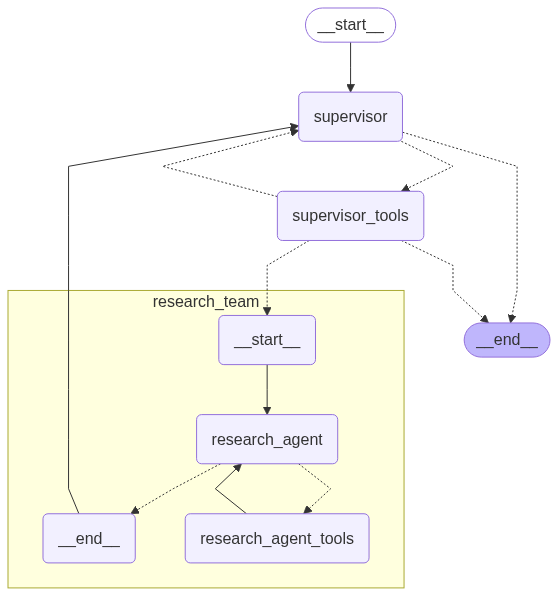

In [8]:
from IPython.display import Image, display, Markdown
display(Image(agent.get_graph(xray=True).draw_mermaid_png(max_retries=5)))

In [9]:
relevant_docs = retriever.get_relevant_documents(question)
context = "\n\n".join([doc.page_content for doc in relevant_docs])

<ipython-input-9-3a966e712424>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_docs = retriever.get_relevant_documents(question)


In [17]:
msg = [{
    "role": "user",
    "content": f"""
You are an expert AI researcher with access to a company's annual report (see context below) and online search tools. Your task is to synthesize this information into a structured report.

**CRITICAL INSTRUCTIONS FOR CITATION:**
1.  You **must** cite every piece of information, data point, or claim in your response.
2.  Use inline, numbered citations in square brackets at the end of each sentence or claim, for example: "The company's revenue grew by 10% [1]."
3.  The provided PDF Context (the annual report) **must** be your first source, cited as `[1]`.
4.  Any new information you find online will be your subsequent sources, numbered sequentially (`[2]`, `[3]`, etc.).
5.  At the very end of your response, create a section titled "**References**". This section must list all sources with their corresponding numbers.
    - For source `[1]`, list it as: "1. {company_name} Annual Report (Provided Context)".
    - For all external web sources, list the article title and a clickable direct URL. For example: "2. [Article Title](https://example.com/article_url)".

**REPORT STRUCTURE:**
1.  **Internal Insights:** Analysis based **exclusively** on the provided `{company_name}` Annual Report. Remember to cite every statement with `[1]`.
2.  **External Insights:** Supplementary or recent information found online. Remember to cite every statement with its corresponding source number (e.g., `[2]`, `[3]`).
3.  **Summary:** A high-level synthesis of the key findings from both internal and external sources. Every claim in the summary must also be cited correctly.
4.  **References:** The numbered list of all sources used in the report.

You must only use reliable, recent information from official websites, reputable news outlets, or financial databases for your external search. Do not ask follow-up questions.

---

### Company:
{company_name}

### PDF Context:
{context}

### Question:
{question}
"""
}]


# ------------------------------------------
# STEP 6: Config
# ------------------------------------------
config = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "tavily",
    "supervisor_model": "openai:o3",
    "researcher_model": "openai:o3"
}

thread_config = {"configurable": config}
# ------------------------------------------
# STEP 7: Run Agent + Log to MLflow
# ------------------------------------------

# mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("OpenDeepResearch_PDF_QA")

import asyncio

async def main():
    with mlflow.start_run():
        run = mlflow.active_run()
        print(f"🚀 MLflow Run ID: {run.info.run_id}")
        print(f"🔗 MLflow Run URL: http://127.0.0.1:5000/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")

        mlflow.log_param("query", question)
        mlflow.log_metric("context_length", len(context))

        # Run the agent
        response = await agent.ainvoke({"messages": msg}, config=thread_config)

        # Extract LangChain message objects from state
        messages = agent.get_state(thread_config).values["messages"]

        # print(messages)

        # Extract final assistant message safely
        # assistant_msgs = [m.content for m in messages if getattr(m, "role", None) == "AIMessage"]
        from langchain_core.messages import AIMessage

        ai_messages = [
            m for m in agent.get_state(thread_config).values['messages']
            if isinstance(m, AIMessage) and m.content.strip()
        ]

        final_response = next(
                            (m.content for m in reversed(ai_messages) if m.content.strip()),
                            None
                        )

        if final_response:
            final_report = final_response
            print("📄 Final Report:\n")
            print(final_report)
            mlflow.log_text(final_report, "final_report.txt")
        else:
            print("⚠️ No assistant response found.")

await main()


🚀 MLflow Run ID: 2c871d96cb7e4cef980a29b5c7152780
🔗 MLflow Run URL: http://127.0.0.1:5000/#/experiments/316236617365355717/runs/2c871d96cb7e4cef980a29b5c7152780
📄 Final Report:

Internal Insights  
• Foreign-currency fluctuation is a significant financial risk. A 5 % move in the USD, EUR or CNY versus the rupee would swing FY 25 profit by ₹111 lakh, ₹1,794 lakh and ₹-19 lakh respectively, and change total equity by a similar magnitude, underscoring earnings sensitivity to exchange rates given the company’s heavy export mix (76 %–87 % of Crop-Protection revenue) [1].  
• Interest-rate risk is material because the company carries both long- and short-term borrowings at floating rates; management tries to balance fixed- and variable-rate debt to dampen the effect of rate volatility on cash flows [1].  
• Market-risk management is centralised in the treasury function, which oversees hedging, credit control and compliance with risk limits; however, the Board acknowledges that unexpected mar

In [11]:
!pip install -q pyngrok
from pyngrok import ngrok

In [18]:
ngrok_token = userdata.get('NGROK_AUTHTOKEN')
ngrok.set_auth_token(ngrok_token)
get_ipython().system_raw("mlflow ui --port 5000 &")
public_url = ngrok.connect(5000)
print(f"🔗 Public MLflow URL: {public_url}")

🔗 Public MLflow URL: NgrokTunnel: "https://77d2-35-203-140-16.ngrok-free.app" -> "http://localhost:5000"
